<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2022_hands_on/blob/main/Week05_Convolutional_Neural_Network_with_CIFAR10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 05

## Introduction

In this notebook, we are going to learn about

*   Convolutional Neural Network (CNN)
*   Conv2D Layer
*   MaxPooling 2D Layer

Last week, we implemented a simple MLP model for classifying three different irises from their four feature values. The model we used was made with simple linear layers. Such models can be applied for image recognition tasks as well, but not very efficient.

On the other hand, CNNs are more suitable for image recognition tasks. Thanks to the invention of CNNs, the accuracy of image recognition AI has been improved drastically, and now beyond human levels. Today, most of modern image recognition AIs use CNNs.

We are going to build a simple CNN model and train it with CIFAR10 dataset. CIFAR10 dataset consists of 10 categories of 32x32 pixels' color images as shown bellow. 

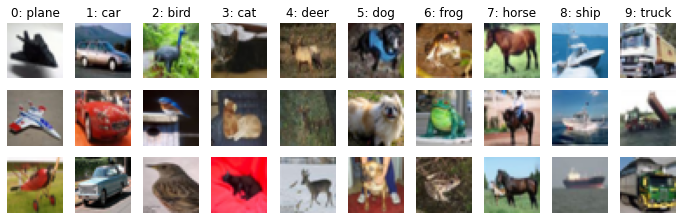

### GPU

We will need a GPU to train CNN models. Please make sure your runtime type is GPU now.

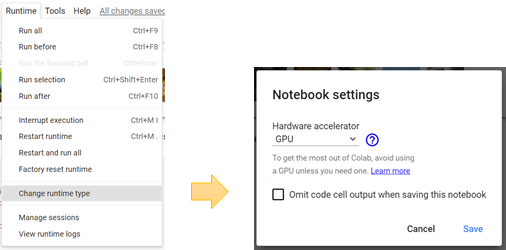

We can check if GPU (cuda) is available.

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


### Import Packages

Let's import general Python packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## Data Preparation

### CIFAR10 Dataset

CIFAR10 dataset can be loaded from `torchvision.datasets`. The `torchvision` package consists of several popular datasets, model architectures, and common image transformations for computer vision.

*   CIFAR10 https://www.cs.toronto.edu/~kriz/cifar.html
* torchvison https://pytorch.org/vision/stable/index.html

In [3]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(root="cifar10", train=True, download=True)
test_dataset = CIFAR10(root="cifar10", train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


CIFAR10 datasets consists of 50,000 and 10,000 labeled images for training and testing respectively.

In [4]:
print("train dataset", len(train_dataset))
print("test dataset", len(test_dataset))

train dataset 50000
test dataset 10000


We can take individual set of image and label by indexing the dataset. The image data is in PIL format and this can be visualized with matplotlib.

* Pillow (PIL Fork) https://pillow.readthedocs.io/en/latest/handbook/index.html

type of image: <class 'PIL.Image.Image'>
size of image: (32, 32)
label: 6


Text(0.5, 1.0, '6')

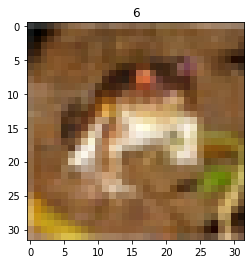

In [5]:
image, label = train_dataset[0]

print("type of image:", type(image))
print("size of image:", image.size)
print("label:", label)

plt.imshow(image)
plt.title(label)

The label number corresponds to 10 categories as shown below.

In [6]:
classnames = {0:"plane", 
              1:"car", 
              2:"bird", 
              3:"cat", 
              4:"deer",
              5:"dog", 
              6:"frog", 
              7:"horse",
              8:"ship",
              9:"truck"}

classnames

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### torch.tensor

In order to handle data with PyTorch, the data format needs to be in `torch.tensor`. We can get `torch.tensor` data by specifying the parameter of `transform=transforms.ToTensor()` when loading from `torchvision.datasets`.

In [7]:
from torchvision import transforms

train_dataset = CIFAR10(root="cifar10", train=True, download=False, transform=transforms.ToTensor())
test_dataset = CIFAR10(root="cifar10", train=False, download=False, transform=transforms.ToTensor())

Now the image data is in `torch.tensor`.

In [8]:
image, label = train_dataset[0]
print(type(image))

<class 'torch.Tensor'>


Note that one of the differences between `PIL` and `torch.tensor` image data is its order of data shape as shown below.

|  data format  |  shape  |
| :----: | :----: |
|  PIL  |  (32, 32, 3)  <br> (height, width, channel)|
|  torch.tensor  |  (3, 32, 32)  <br> (channel, height, width)|


The image data with the shape of (3, 32, 32) cannot be visualized using matplotlib.


TypeError: ignored

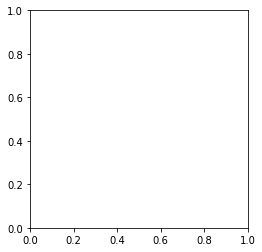

In [9]:
plt.imshow(image)    # this raises an error

### DataLoader

We create `DataLoader` objects for feeding dataset to a PyTorch model. This is exactly same as we did with Iris dataset.

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

That's it for data preparation!

## Model Building

### Model Architecture

Next step is to build a convolutional neural network (CNN). We will build a model shown below. The model consists of two parts. The first one is named "features", and the second one is named "classifier". The features part consists of Conv2d (2D convolution) layers with ReLU actiovation function and MaxPool2D layers. The classifier part consists of Linear layers with ReLU activation functions. The features part extracts features of input image and the flatten layer converts it to 1D feature data. Then the classifier part classifies the image class from feature data.

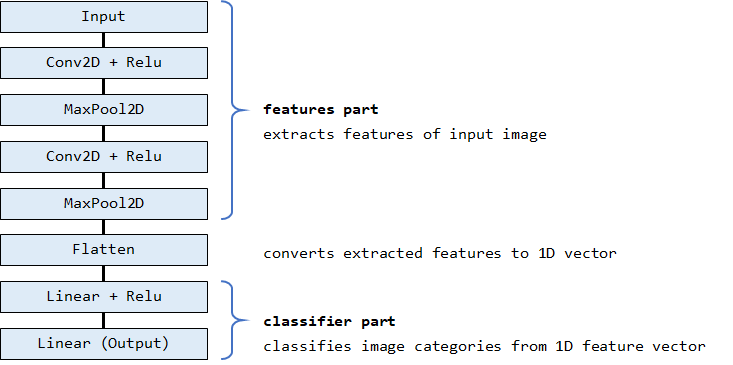

In [11]:
import torch.nn as nn

# define a class named "Model"
class Model(nn.Module):

    # Constructor
    def __init__(self):                 # do not change
        super(Model, self).__init__()   # do not change
        
        # define a network module named "features"
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # define a network module named "classifier"
        self.classifier = nn.Sequential(
            nn.Linear(in_features=128*8*8, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10)
        )

    # Instance method
    def forward(self, x):   # do not change
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        return x
    
model = Model()    # construct an instance of the Model class
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


Then we load the model on GPU.

In [12]:
model = model.to(device)

Let's visualize the model architecture with torchinfo package. This is very useful to know how the data shape changes as it propagates in the model.

In [13]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print("\ninput data shape:", input_shape)

summary(model, input_shape)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

input data shape: torch.Size([50, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [50, 10]                  --
├─Sequential: 1-1                        [50, 128, 8, 8]           --
│    └─Conv2d: 2-1                       [50, 64, 32, 32]          1,792
│    └─ReLU: 2-2                         [50, 64, 32, 32]          --
│    └─MaxPool2d: 2-3                    [50, 64, 16, 16]          --
│    └─Conv2d: 2-4                       [50, 128, 16, 16]         73,856
│    └─ReLU: 2-5                         [50, 128, 16, 16]         --
│    └─MaxPool2d: 2-6                    [50, 128, 8, 8]           --
├─Sequential: 1-2                        [50, 10]                  --
│    └─Linear: 2-7                       [50, 256]                 2,097,408
│    └─ReLU: 2-8                         [50, 256]                 --
│    └─Linear: 2-9                       [50, 10]                  2,570
Total params: 2,175,626
Trainable params: 2,175,626
Non-trainable pa

### Conv2D Layer

The Conv2D layer creates output data by convoluting (calculating sum of element wise products of) the input data and the filters (i.e. kernels). The size of filters are usually smaller than the input data, therefore the filters are moved across the whole input data. Usually several different filters are used in a Conv2D layer resulting in several different output data. Numbers in the filters are the trainable parameters, therefore these values are updated during training.

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

#### Example-1

`nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0)`
*   Input data is a grayscale image with the size of (1x6x6), therefore `in_channels=1`
*   Use only one filter with the size of (1x3x3), therefore `out_channels=1`, `kernel_size=3`
*   No paddings are applied, therefore `padding=0`



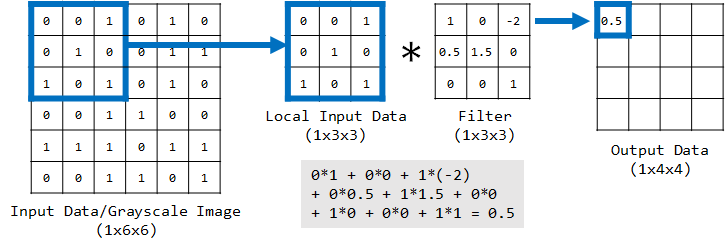

#### Example-2

`nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=0)`
*   Input data is a color image with the size of (3x6x6), therefore `in_channels=3`
*   Use only 1 filter with the size of (3x3x3), therefore `out_channels=1`, `kernel_size=3`
*   No paddings are applied, therefore `padding=0`


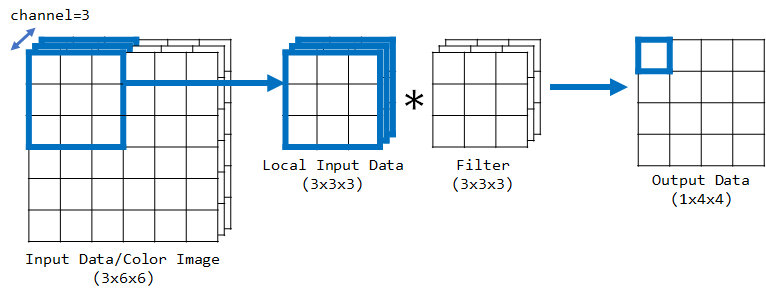

#### Example-3
`nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=0)`
*   Input data is a color image with the size of (3x6x6), therefore `in_channels=1`
*   Use 5 filters with the size of (3x3x3), therefore `out_channels=5`, `kernel_size=3`
*   No paddings are applied, therefore `padding=0`

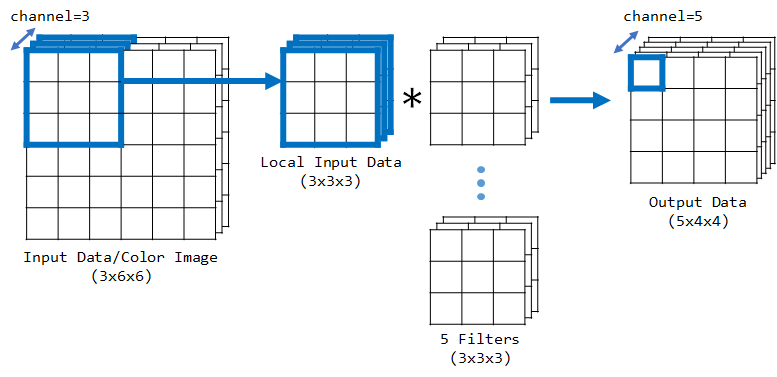

#### Example-4
`nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1)`
*   Input data is the output data of Example-3 (5x4x4), therefore `in_channels=5`
*   Use 10 filters with kernel size of (5x3x3), therefore `out_channels=5`, `kernel_size=3`
*   Paddings are applied to all 4 sides, therefore `padding=1`

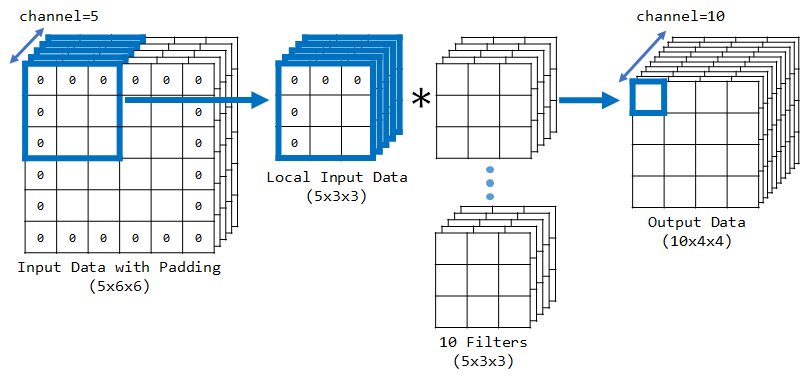

You can play with the code below to see how the Conv2D layer works.

Text(0.5, 1.0, 'Convoluted Image')

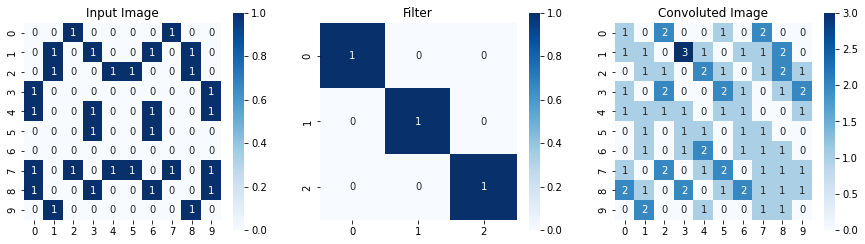

In [14]:
# input image (10x10) --- do not change
input_img = torch.tensor([0,0,1,0,0,0,0,1,0,0,
                          0,1,0,1,0,0,1,0,1,0,
                          0,1,0,0,1,1,0,0,1,0,
                          1,0,0,0,0,0,0,0,0,1,
                          1,0,0,1,0,0,1,0,0,1,
                          0,0,0,1,0,0,1,0,0,0,
                          0,0,0,0,0,0,0,0,0,0,
                          1,0,1,0,1,1,0,1,0,1,
                          1,0,0,1,0,0,1,0,0,1,
                          0,1,0,0,0,0,0,0,1,0], dtype=torch.float32)
input_img = input_img.view(1, 1, 10, 10)

# define a Conv2d layer
conv = nn.Conv2d(in_channels=1,
                 out_channels=1,
                 kernel_size=3,
                 padding=1,
                 bias=False)

# set weights of the Conv2D layer
weights = (torch.tensor([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1]]).view(1, 1, 3, 3).float()
                         )
conv.weight = nn.Parameter(weights)

# Execute convolutional operation
conv_img = conv(input_img)

# Visualize input image, filter and output image
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.heatmap(torch.squeeze(input_img).numpy(), annot=True, square=True, cmap="Blues")
plt.title(f"Input Image")

plt.subplot(1,3,2)
sns.heatmap(torch.squeeze(weights).numpy(), annot=True, square=True, cmap="Blues")
plt.title(f"Filter")

plt.subplot(1,3,3)
sns.heatmap(torch.squeeze(conv_img).detach().numpy(), annot=True, square=True, cmap="Blues")
plt.title(f"Convoluted Image")

### MaxPool2D Layer

MaxPool2D layer creates down-sampled output images by taking the maximum number in a partial area of input images.

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

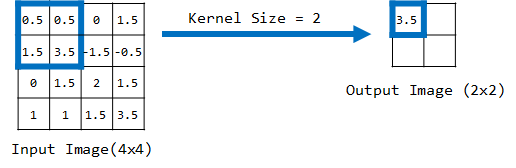

Text(0.5, 1.0, 'Pooled Image')

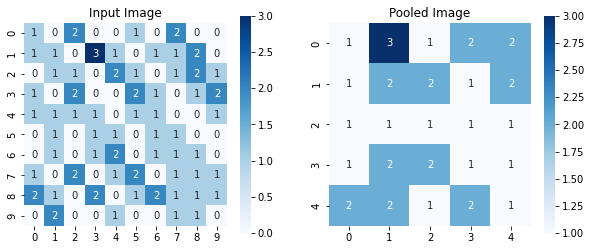

In [15]:
# Define a MaxPool2d Layer
max_pool = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)

# Execute pooling
pool_img = max_pool(conv_img)

# visualize input and output data
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap(torch.squeeze(conv_img).detach().numpy(), annot=True, square=True, cmap="Blues")
plt.title("Input Image")

plt.subplot(1,2,2)
sns.heatmap(torch.squeeze(pool_img).detach().numpy(), annot=True, square=True, cmap="Blues")
plt.title("Pooled Image")

## Training

### Loss Function

We use the cross-entropy loss as the loss function since this is a classification task.

In [16]:
loss_func = nn.CrossEntropyLoss()

### Optimizer

We use the Adam optimizer.

In [17]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### Training Loop
Now we train the model with CIFAR10 datasets. The training loop is almost same as we did last week, except for that we load the dataset and the model on GPU.







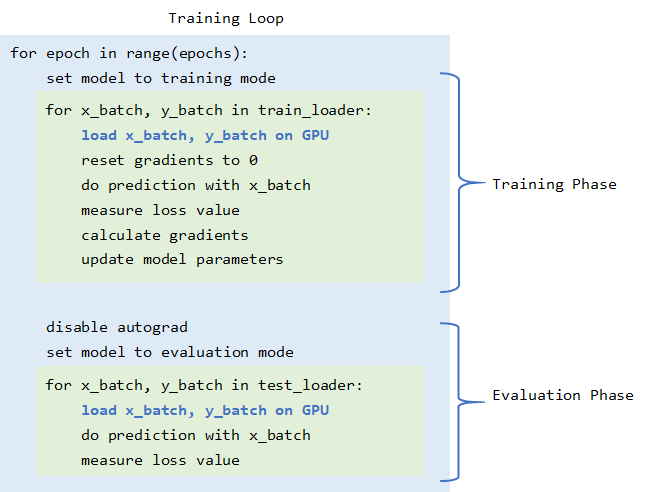

In [18]:
model = Model().to(device)                             # load model to GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer

epochs = 10

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    for x_batch, y_batch in tqdm(train_loader): # take mini batch data from train_loader

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        for x_batch, y_batch in tqdm(test_loader):   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions
    #------------------------#

    train_accuracy = train_correct_count/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy.item())
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy.item())
    test_loss_list.append(test_loss)

-----------------------------
Epoch 1/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.506 Loss=1.370, Test: Accuracy=0.618 Loss=1.075
-----------------------------
Epoch 2/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.650 Loss=0.983, Test: Accuracy=0.677 Loss=0.906
-----------------------------
Epoch 3/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.711 Loss=0.819, Test: Accuracy=0.695 Loss=0.878
-----------------------------
Epoch 4/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.756 Loss=0.694, Test: Accuracy=0.706 Loss=0.865
-----------------------------
Epoch 5/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.793 Loss=0.589, Test: Accuracy=0.713 Loss=0.844
-----------------------------
Epoch 6/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.827 Loss=0.491, Test: Accuracy=0.709 Loss=0.901
-----------------------------
Epoch 7/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.861 Loss=0.397, Test: Accuracy=0.715 Loss=0.939
-----------------------------
Epoch 8/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.888 Loss=0.316, Test: Accuracy=0.720 Loss=0.976
-----------------------------
Epoch 9/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.917 Loss=0.236, Test: Accuracy=0.716 Loss=1.070
-----------------------------
Epoch 10/10


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Train: Accuracy=0.936 Loss=0.182, Test: Accuracy=0.718 Loss=1.229


### Learning Curves

Let's visualize the accuracy curves for train and test data.

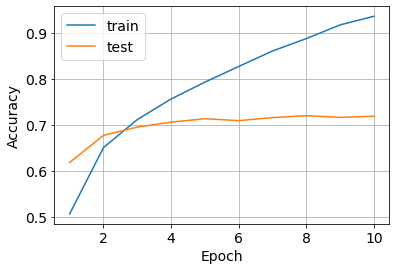

In [19]:
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

Also let's visualize the loss curves for train and test data.

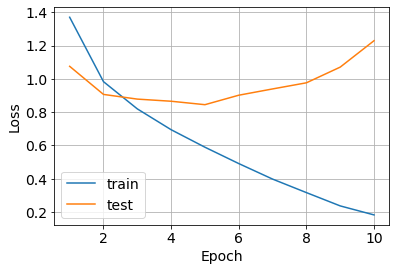

In [20]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

### Overfit

Maybe you have noticed that the test accuracy saturates after first several epochs while the training accuracy keeps increasing. Also the test loss stops decreasing and starts to increase  while the training loss keeps decreasing. 

This means the model is trained too much for training dataset, i.e. the model can predict very well for only the training data, but not for any other data including test dataset. This behavior is called overfit.

Generally speeking, deep neural network models tend to overfit easily because they have huge number of trainable parameters. The models can just remenber the training dataset instead of understanding general features.

But today, there are several techniques for avoiding overfitting the models. We will learn them next week.

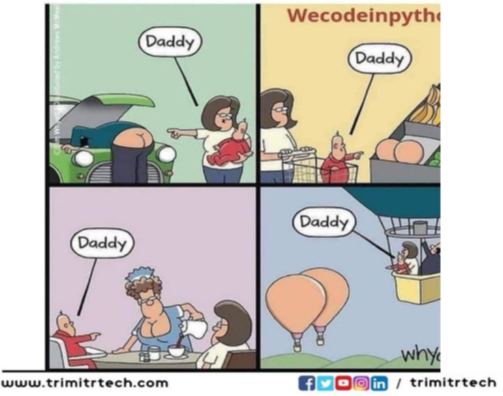

## Evaluation

### Test Accuracy

Let's check the accuracy of the model for all of the test data.

In [21]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode
    
    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.718


### Confusion Matrix

Then let's check the confusion matrix.

Text(0.5, 1.0, 'confusion matrix')

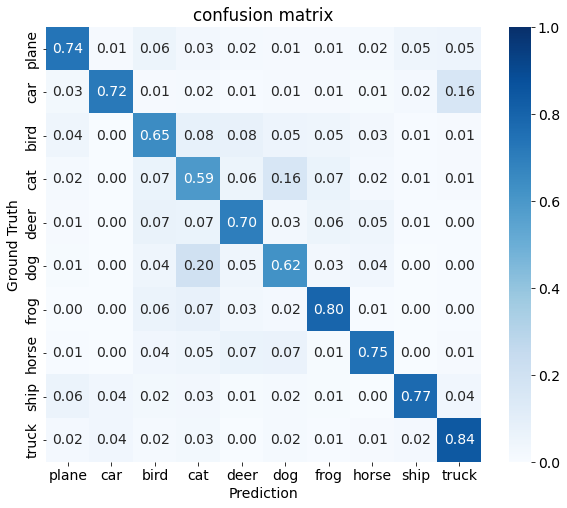

In [22]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,8))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("Ground Truth")
plt.xlabel("Prediction")
plt.title("confusion matrix")

### Predictions for Test Data

Let's see predictions for some test data.

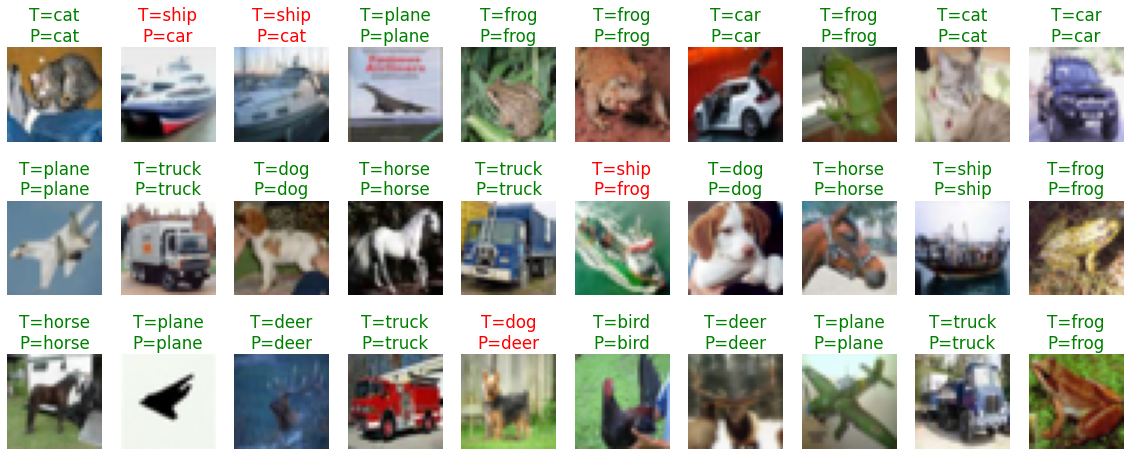

In [23]:
plt.figure(figsize=(20, 8))

for i in range(30):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))
    plt.subplot(3, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")


## Practice

Modify the model as shown below, and train it again.

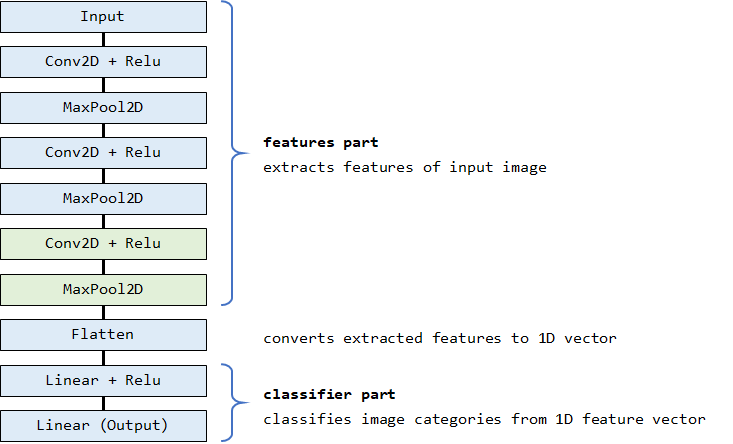

## Conclusion
That's it for this week. Now you can try to improve the test accuracy by changing hyper parameters.